In [5]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Importer les bibliothèques nécessaires

# Pour manipuler les bases de données et les graphes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Pour le ML
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from bayes_opt import BayesianOptimization



In [8]:
# Charger le jeu de données
path = "/home/onyxia/work/statapp_sujet26/"
#enlever work si nécessaire
file_name1 = "dataset_complet_avec_dummies_part_1.csv"
file_name2 = "dataset_complet_avec_dummies_part_2.csv"
file_name3 = "dataset_complet_avec_dummies_part_3.csv"
file_name4 = "dataset_complet_avec_dummies_part_4.csv"
df1 = pd.read_csv(path+file_name1, sep=',',low_memory=False)
df2 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df3 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df4 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df = pd.concat([df1,df2,df3,df4])

df['grav'] = df['grav'].replace({1:0,2:0,3:1,4:1})

In [9]:
y = df['grav']
X = df.drop(columns=['grav'])
features = X.columns

#print(X.head())
#print(y.head())
#print(features)

In [10]:
# Diviser les données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normaliser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Définir une grille de paramètres à rechercher
param_grid = {
    'max_depth': [5, 15, 25],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [200, 400, 600],
}

# Initialiser le modèle XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Initialiser StratifiedKFold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser GridSearchCV avec le modèle, la grille de paramètres et StratifiedKFold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_fold, scoring='f1')

# Exécuter la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

model = grid_search.best_estimator_

Best Parameters: {'colsample_bytree': 0.8, 'max_depth': 25, 'n_estimators': 400, 'subsample': 0.9}
Best Score: 0.8444783434819968


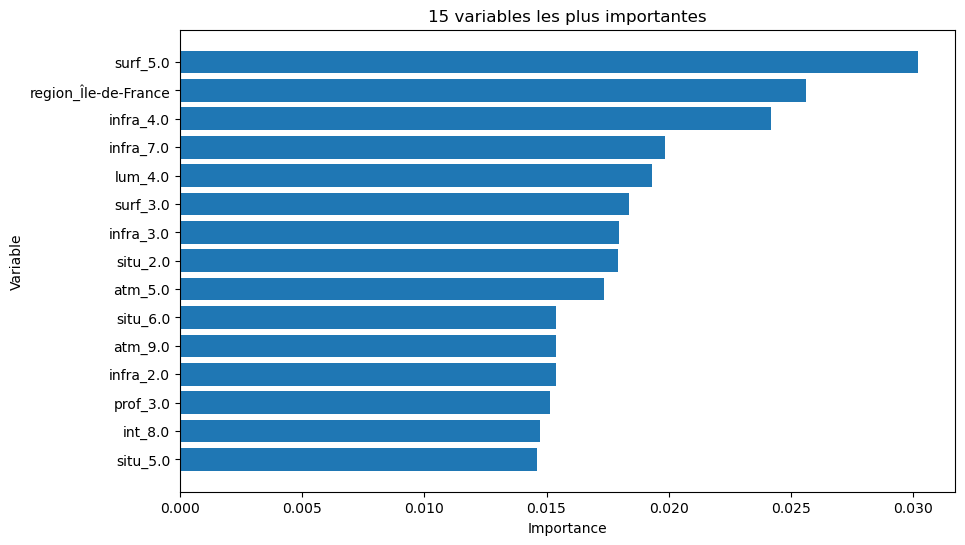

In [11]:
# Obtenir l'importance des variables à partir du modèle entraîné
importance = model.feature_importances_

# Créer un dictionnaire pour stocker l'importance de chaque variable avec son nom
feature_importance_dict = dict(zip(features, importance))

# Trier les variables par importance et sélectionner les 15 premières
top_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:15]

# Extraire les noms des 15 variables les plus importantes
top_feature_names = [feature[0] for feature in top_features]
top_importance = [feature[1] for feature in top_features]

# Tracer l'importance des 15 variables les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_importance)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('15 variables les plus importantes')
plt.gca().invert_yaxis()  # Inverser l'axe y pour avoir la variable la plus importante en haut


plt.show()


In [12]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("Score F1 sur l'ensemble de test:", f1)

Score F1 sur l'ensemble de test: 0.8692570869990225


In [13]:
def graph(model, param_name, param_range):
    # Calculer les scores d'entraînement et de validation à travers la plage de valeurs de l'hyperparamètre
    train_scores, valid_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=k_fold, scoring='f1')

    # Calculer les scores moyens et les écarts-types pour les scores d'entraînement et de validation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Tracer les courbes de validation
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Score d\'entraînement')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(param_range, valid_mean, color='green', linestyle='--', marker='s', markersize=5, label='Score de validation')
    plt.fill_between(param_range, valid_mean + valid_std, valid_mean - valid_std, alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Valeur de ' + param_name)
    plt.ylabel('Score F1')
    plt.legend(loc='lower right')
    plt.title('Courbes de validation')
    plt.show()


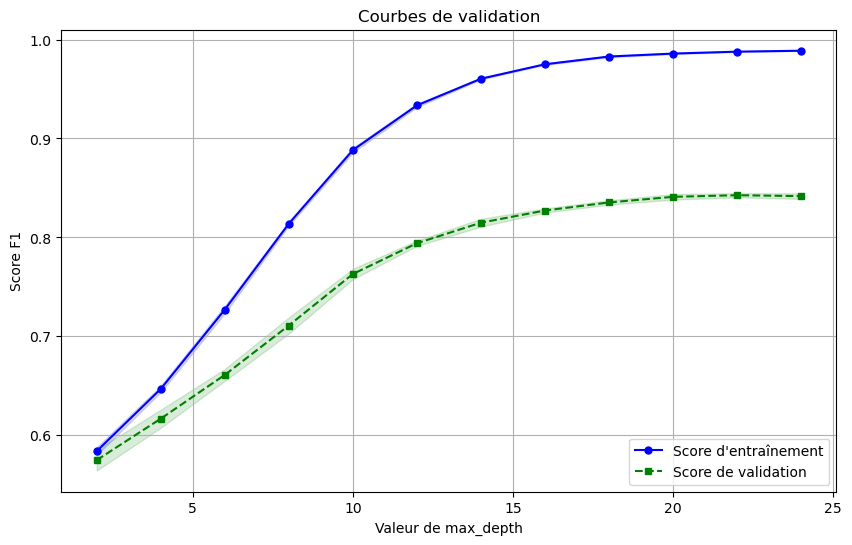

In [21]:
graph(model=model, param_name='max_depth', param_range=range(2,25,2))

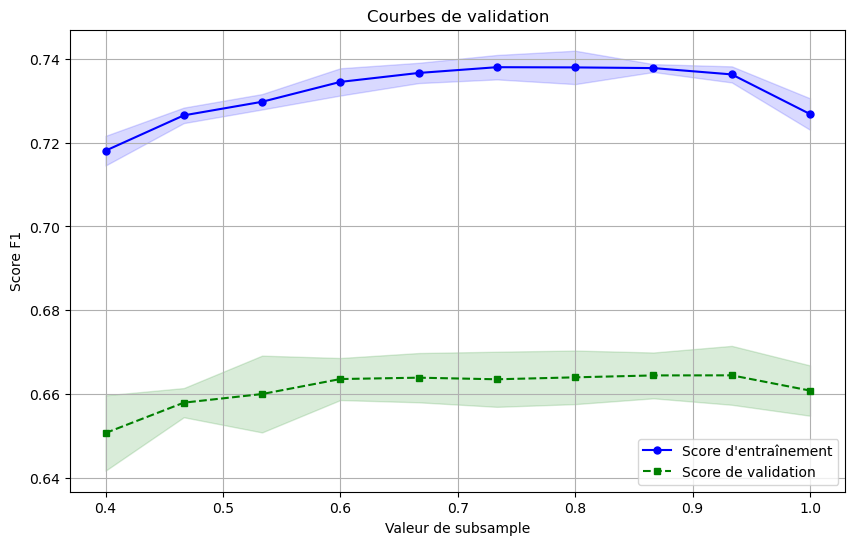

In [22]:
graph(model=model, param_name='subsample', param_range=np.linspace(0.4,1,10))

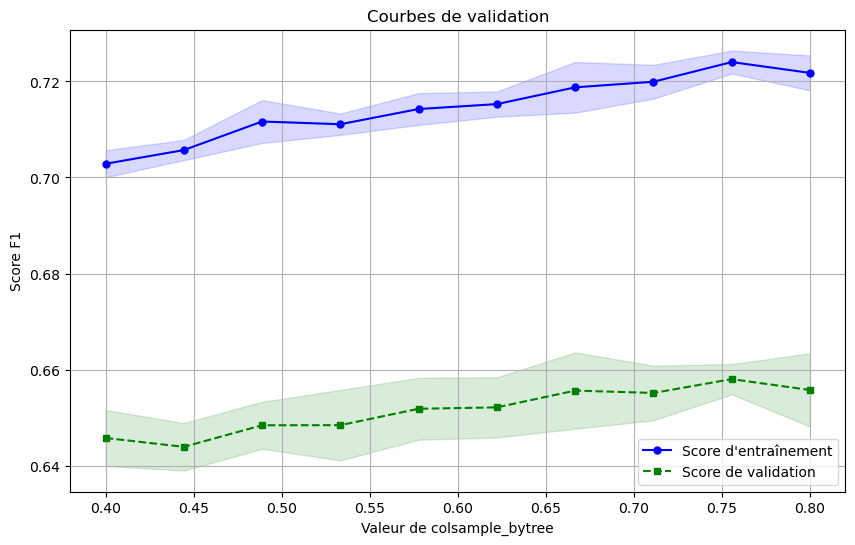

In [23]:
graph(model=model, param_name='colsample_bytree', param_range=np.linspace(0.4,0.8,10))

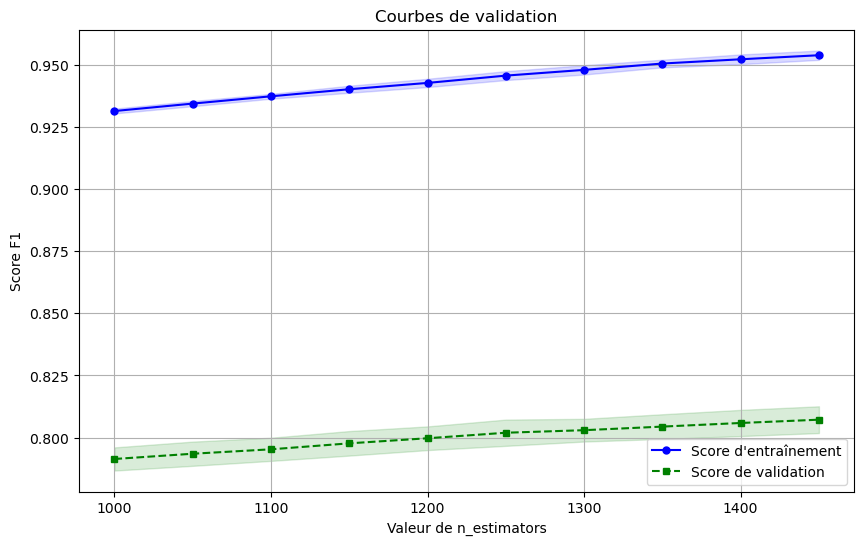

In [26]:
graph(model=model, param_name='n_estimators', param_range=range(1000,1500,50))

In [29]:
best_params = {
    'max_depth': 25,
    'subsample': 0.9,
    'colsample_bytree': 0.75,
    'n_estimators': 1000,
}

model = xgb.XGBClassifier(objective='binary:logistic', max_depth=20, subsample=0.9, colsample_bytree=0.75, n_estimators=700, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("Score F1 sur l'ensemble de test:", f1)

Score F1 sur l'ensemble de test: 0.8673020527859238


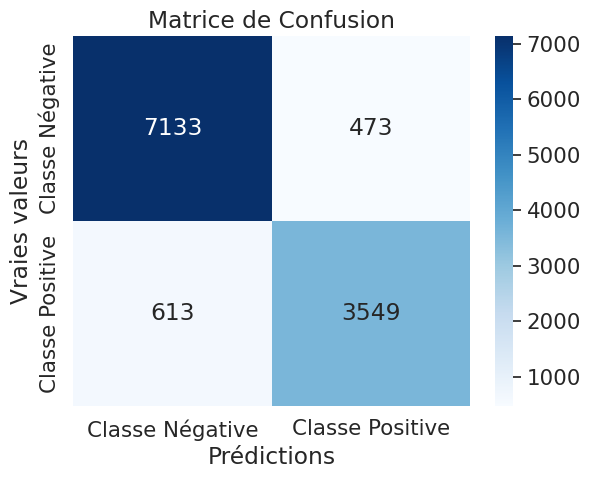

In [30]:
cm = confusion_matrix(y_test, y_pred)

# Création de la heatmap
sns.set(font_scale=1.4)  # Ajustement de l'échelle de la police pour une meilleure visualisation
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Classe Négative', 'Classe Positive'], 
            yticklabels=['Classe Négative', 'Classe Positive'])

# Ajout de labels et de titres
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')

# Affichage de la figure
plt.show()


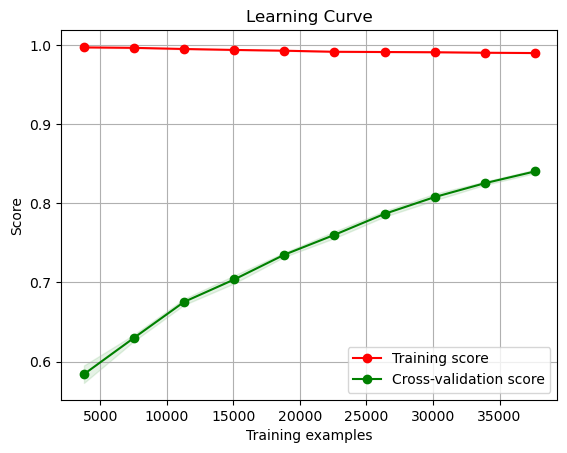

In [19]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='f1', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Utilisez cette fonction en passant votre modèle entraîné, le titre de la courbe, vos données et d'autres paramètres
plot_learning_curve(model, "Learning Curve", X_train, y_train, cv=k_fold, train_sizes=np.linspace(.1, 1.0, 10))
plt.show()


## SUITE BROUILLON

In [20]:
# Définir une grille de paramètres à rechercher
param_space = {
    'max_depth': (3, 10),
    'subsample': (0.7, 0.9),
    'colsample_bytree': (0.7, 0.9),
    'n_estimators': (50, 200),
}

# Initialiser le modèle XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Initialiser StratifiedKFold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser BayesSearchCV avec le modèle, l'espace de recherche de paramètres et StratifiedKFold
bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, cv=k_fold, scoring='f1', n_jobs=-1, verbose=3)

# Exécuter la recherche bayésienne
bayes_search.fit(X, y)

# Afficher les meilleurs paramètres et le meilleur score
print("Best Parameters:", bayes_search.best_params_)
print("Best Score:", bayes_search.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END colsample_bytree=0.819509347336377, max_depth=6, n_estimators=51, subsample=0.862463072668841;, score=0.635 total time=   1.4s
[CV 4/5] END colsample_bytree=0.819509347336377, max_depth=6, n_estimators=51, subsample=0.862463072668841;, score=0.627 total time=   1.4s[CV 2/5] END colsample_bytree=0.819509347336377, max_depth=6, n_estimators=51, subsample=0.862463072668841;, score=0.639 total time=   1.4s

[CV 1/5] END colsample_bytree=0.819509347336377, max_depth=6, n_estimators=51, subsample=0.862463072668841;, score=0.627 total time=   1.4s
[CV 5/5] END colsample_bytree=0.819509347336377, max_depth=6, n_estimators=51, subsample=0.862463072668841;, score=0.651 total time=   1.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END colsample_bytree=0.8089191579071751, max_depth=5, n_estimators=106, subsample=0.7028686853452232;, score=0.649 total time=   1.9s
[CV 5/5] END colsample_bytree=0.8089191

KeyboardInterrupt: 

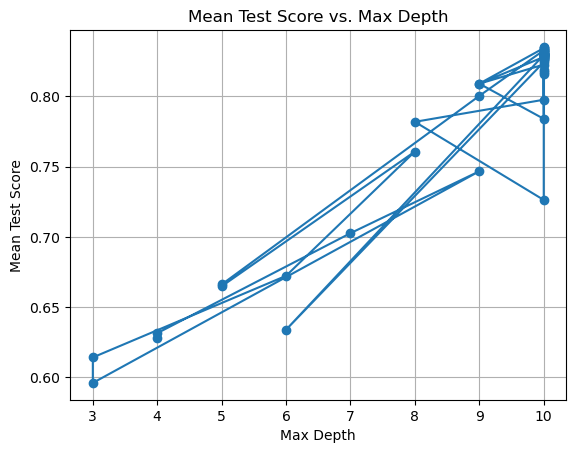

In [ ]:
# Extraire les résultats de la recherche
results = bayes_search.cv_results_

# Extraire les valeurs de la profondeur maximale de l'arbre et les scores correspondants
max_depths = results['param_max_depth'].data
mean_scores = results['mean_test_score']

# Tracer le score moyen en fonction de la profondeur maximale de l'arbre
plt.plot(max_depths, mean_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. Max Depth')
plt.grid(True)
plt.show()


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.797    | 0.6873    | 0.9512    | 0.2223    | 7.191     | 2.404     | 240.4     | 0.529     |
| 2         | -0.7628   | 0.9331    | 0.6051    | 0.2153    | 3.144     | 9.729     | 849.2     | 0.6062    |
| 3         | -0.7779   | 0.5909    | 0.1916    | 0.09823   | 6.673     | 4.888     | 362.1     | 0.8059    |
| 4         | -0.7717   | 0.5697    | 0.2992    | 0.1162    | 6.192     | 8.067     | 279.7     | 0.7571    |
| 5         | -0.7929   | 0.7962    | 0.05599   | 0.1862    | 4.194     | 1.585     | 954.0     | 0.9828    |
| 6         | -0.7634   | 0.9042    | 0.3116    | 0.03832   | 7.79      | 4.961     | 209.8     | 0.7476    |
| 7         | -0.7889   | 0.5172    | 0.9102    | 0.08505   | 7.638     | 3.805     | 568.1     | 0.7734    |
| 8       

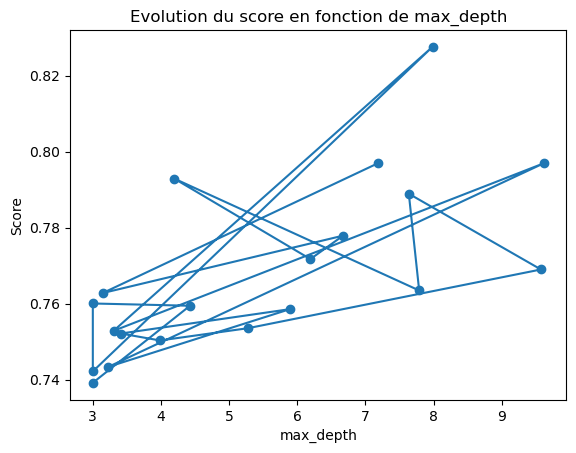

In [ ]:
from sklearn.model_selection import cross_val_score

# Définir une fonction pour la recherche bayésienne avec validation croisée K-fold
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    params = {'max_depth': int(max_depth),
              'learning_rate': learning_rate,
              'n_estimators': int(n_estimators),
              'gamma': gamma,
              'min_child_weight': min_child_weight,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'objective': 'binary:logistic',
              'nthread': -1,
              'eval_metric': 'logloss'}
    model = XGBClassifier(**params)
    cv_scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
    return -np.mean(cv_scores)

# Diviser les données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Définir les bornes des hyperparamètres
pbounds = {'max_depth': (3, 10),
           'learning_rate': (0.01, 0.3),
           'n_estimators': (100, 1000),
           'gamma': (0.01, 1),
           'min_child_weight': (1, 10),
           'subsample': (0.5, 1),
           'colsample_bytree': (0.5, 1)}

# Effectuer la recherche bayésienne
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=10)

# Tracer l'évolution du score en fonction du paramètre souhaité
param_to_plot = 'max_depth'  # Changer le paramètre à tracer selon votre besoin
values = [x['params'][param_to_plot] for x in optimizer.res]
scores = [-x['target'] for x in optimizer.res]

plt.plot(values, scores, marker='o')
plt.xlabel(param_to_plot)
plt.ylabel('Score')
plt.title('Evolution du score en fonction de {}'.format(param_to_plot))
plt.show()
